In [1]:
from typing import List, Optional, Union

import arviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
import seaborn as sns
import xarray
from dataandcoords import set_data_and_coords
from scipy import linalg, spatial, special
from scipy.special import expit as logistic
from scipy.special import logit
from zerosumnormal import ZeroSumNormal

if pm.math.erf.__module__.split(".")[0] == "theano":
    import theano.tensor as aet
else:
    import aesara.tensor as aet

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
arviz.style.use("arviz-darkgrid")
ELECTION_DAY = "2017-04-23"
PARTIES_COMPLETE = [
    "farleft",
    "left",
    "center",
    "right",
    "farright",
    "other",
]
RANDOM_SEED = 8927
np.random.seed(286)

## Data

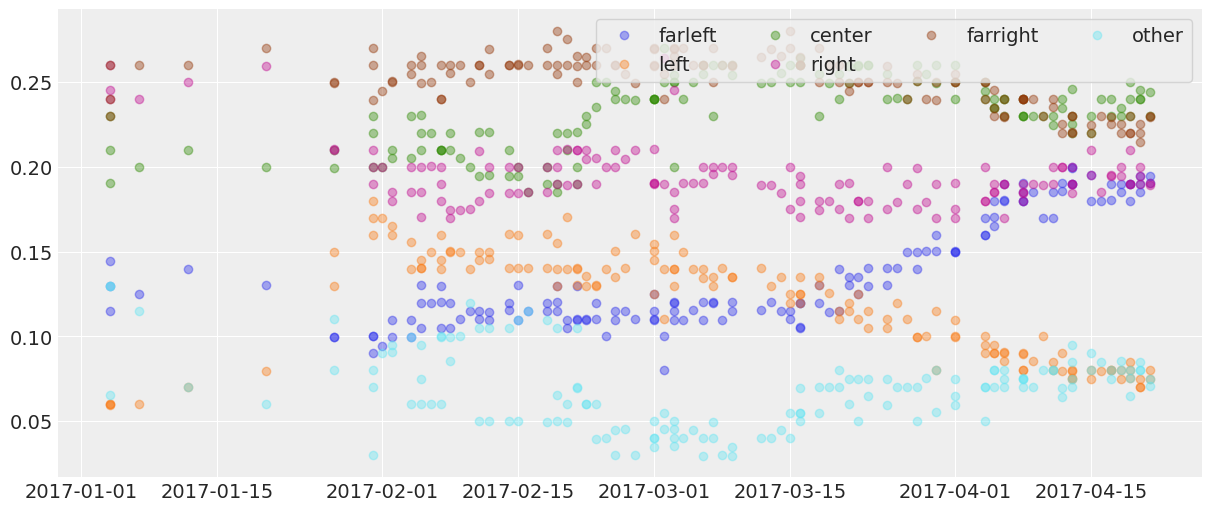

In [6]:
(
    polls_train,
    polls_test,
    results,
    observed_days_id,
    estimated_days,
    pollster_id,
    COORDS,
) = set_data_and_coords(election_date=ELECTION_DAY, parties_complete=PARTIES_COMPLETE)

## GP approximation

In [17]:
def make_sum_zero_hh(N: int) -> np.ndarray:
    """
    Build a householder transformation matrix that maps e_1 to a vector of all 1s.
    """
    e_1 = np.zeros(N)
    e_1[0] = 1
    a = np.ones(N)
    a /= np.sqrt(a @ a)
    v = a + e_1
    v /= np.sqrt(v @ v)
    return np.eye(N) - 2 * np.outer(v, v)


def make_centered_gp_eigendecomp(
    time: np.ndarray,
    lengthscale: Union[float, str, List[Union[float, str]]],
    variance_limit: float = 0.95,
    kernel: str = "gaussian",
    metric: str = "euclidean",
    zerosum: bool = False,
    period: Optional[Union[float, str]] = None,
):
    """
    Decompose the GP into eigen values and eigen vectors.

    Parameters
    ----------
    time : np.ndarray
        Array containing the time points of observations.
    lengthscale : float or str or list
        Length scale parameter of the GP. Set in the ``config`` dictionary.
        A list of lengthscales can be provided when using the Gaussian kernel.
        The corresponding covariance matrices will then be added to each other.
    variance_limit : float
        Controls how many of the eigen vectors of the GP are used. So, if
        ``variance_limit=1``, all eigen vectors are used.
    kernel : str
        Select the kernel function from the two available: gaussian or periodic.
    zerosum : bool
        Constrain all basis functions to sum(basis) = 0. The resulting GP will
        thus sum to 0 along the time axis.
    period : float or str
        Only used if the kernel is periodic. Determines the period of the kernel.
    """

    ## Construct covariance matrix
    X = time[:, None]

    if kernel == "gaussian":
        if (
            isinstance(lengthscale, int)
            or isinstance(lengthscale, float)
            or isinstance(lengthscale, str)
        ):
            lengthscale = [lengthscale]
        dists = []
        for ls in lengthscale:
            if isinstance(ls, str):
                ls = pd.to_timedelta(ls).to_timedelta64()
            dists.append(((X - X.T) / np.array(ls)) ** 2)
        cov = sum(np.exp(-(dist) / 2) for dist in dists) / len(lengthscale)

    elif kernel == "periodic":
        if len(lengthscale) > 1:
            raise NotImplementedError(
                f"Multiple lengthscales can only be used with the Gaussian kernel."
            )
        elif isinstance(period, str):
            period = pd.to_timedelta(period).to_timedelta64()
        dists = np.pi * ((time[:, None] - time[None, :]) / period)
        cov = np.exp(-2 * (np.sin(dists) / lengthscale) ** 2)

    else:
        raise ValueError(
            f"Unknown kernel = {kernel}. Accepted values are 'gaussian' and 'periodic'"
        )

    if zerosum:
        Q = make_sum_zero_hh(len(cov))
        D = np.eye(len(cov))
        D[0, 0] = 0

        # 1) Transform the covariance matrix so that the first entry
        # is the mean: A = Q @ cov @ Q.T
        # 2) Project onto the subspace without the mean: B = D @ A @ D
        # 3) Transform the result back to the original space: Q.T @ B @ Q
        cov = Q.T @ D @ Q @ cov @ Q.T @ D @ Q

    vals, vecs = linalg.eigh(cov)
    precision_limit_inds = np.logical_or(vals < 0, np.imag(vals) != 0)

    if np.any(precision_limit_inds):
        cutoff = np.where(precision_limit_inds[::-1])[0][0]
        vals = vals[len(vals) - cutoff :]
        vecs = vecs[:, vecs.shape[1] - cutoff :]

    if variance_limit == 1:
        n_eigs = len(vals)

    else:
        n_eigs = ((vals[::-1].cumsum() / vals.sum()) > variance_limit).nonzero()[0][0]

    return vecs[:, -n_eigs:] * np.sqrt(vals[-n_eigs:])


def make_gp_basis(time, gp_config, key=None, *, model=None):
    model = pm.modelcontext(model)

    if gp_config is None:
        gp_config = {
            "lengthscale": 8,
            "kernel": "gaussian",
            "zerosum": False,
            "variance_limit": 0.99,
        }
    else:
        gp_config = gp_config.copy()
    print(f"{gp_config = }")

    if np.issubdtype(time.dtype, np.datetime64) or (
        str(time.dtype).startswith("datetime64")
    ):
        if (
            gp_config["kernel"] == "gaussian"
            and "lengthscale" in gp_config
            and not isinstance(gp_config["lengthscale"], str)
        ):
            gp_config["lengthscale"] = f"{gp_config['lengthscale'] * 7}D"

    gp_basis_funcs = make_centered_gp_eigendecomp(time, **gp_config)
    n_basis = gp_basis_funcs.shape[1]
    dim = f"gp_{key}_basis"
    model.add_coords({dim: pd.RangeIndex(n_basis)})

    return gp_basis_funcs, dim

In [19]:
GP_CONFIG = {
    "lengthscale": [7, 17, 28],
    "kernel": "gaussian",
    "zerosum": True,
    "variance_limit": 0.95,
}

In [21]:
with pm.Model(coords=COORDS) as plain_mult:
    intercept = ZeroSumNormal("intercept", sigma=0.5, dims="parties_complete")
    bias = ZeroSumNormal(
        "bias", sigma=0.5, dims=("pollsters", "parties_complete"), zerosum_axes=(0, 1)
    )

    # Note: doesn't estimate cov btw parties, nor btw elections

    #   lsd_intercept = pm.Normal("lsd_intercept")
    # sd = pm.HalfNormal("lsd_party_sd")
    # raw = ZeroSumNormal("lsd_party_raw")
    # sd = tt.exp(lsd_intercept + sd * raw)

    shrinkage = pm.HalfNormal("shrinkage", 0.5)
    sd = pm.HalfNormal("time_weight", shrinkage, dims="parties_complete")
    # chol, corr, stds = pm.LKJCholeskyCov(
    #   "chol",
    #  n=len(COORDS["parties_complete"]),
    # eta=5.0,
    # sd_dist=pm.HalfNormal.dist(shrinkage),
    # compute_corr=True,
    # )
    #    pm.Deterministic("time_weight", stds, dims="parties_complete")

    gp_basis_funcs, gp_basis_dim = make_gp_basis(
        time=estimated_days, gp_config=GP_CONFIG, key="parties"
    )
    raw_coefs = ZeroSumNormal(
        f"raw_time_coefs",
        sigma=sd[None, :],
        dims=(gp_basis_dim, "parties_complete"),
        zerosum_axes=-1,
    )

    #    gps = pm.Deterministic(
    #       "time_effect",
    #      aet.dot(gp_basis_funcs, aet.tensordot(chol, raw_coefs, axes=(1, 1)).T),
    #     dims=("estimated_days", "parties_complete"),
    # )
    gps = pm.Deterministic(
        "time_effect",
        aet.dot(gp_basis_funcs, raw_coefs),
        dims=("estimated_days", "parties_complete"),
    )

    # data
    pollster_idx = pm.Data("pollster_idx", pollster_id, dims="observations")
    observed_days_idx = pm.Data(
        "observed_days_idx", observed_days_id, dims="observations"
    )
    observed_N = pm.Data(
        "observed_N", polls_train["samplesize"].values, dims="observations"
    )
    observed_polls = pm.Data(
        "observed_polls",
        polls_train[COORDS["parties_complete"]].values,
        dims=("observations", "parties_complete"),
    )

    # regression
    popularity = pm.Deterministic(
        "popularity",
        aet.nnet.softmax(intercept + bias[pollster_idx] + gps[observed_days_idx]),
        dims=("observations", "parties_complete"),
    )

    # likelihood
    N_approve = pm.Multinomial(
        "N_approve",
        p=popularity,
        n=observed_N,
        observed=observed_polls,
        dims=("observations", "parties_complete"),
    )

    # sampling
    prior_checks = pm.sample_prior_predictive(
        var_names=["time_effect", "popularity", "N_approve"]
    )
    idata = pm.sample(return_inferencedata=True)
    post_checks = pm.sample_posterior_predictive(
        idata, var_names=["time_effect", "popularity", "N_approve"]
    )
    idata.extend(arviz.from_pymc3(prior=prior_checks, posterior_predictive=post_checks))

gp_config = {'lengthscale': 28, 'kernel': 'gaussian', 'zerosum': True, 'variance_limit': 0.95}


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [raw_time_coefs, time_weight, shrinkage, bias, intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 74 seconds.


0, dim: observations, 144 =? 144
1, dim: parties_complete, 1 =? 6


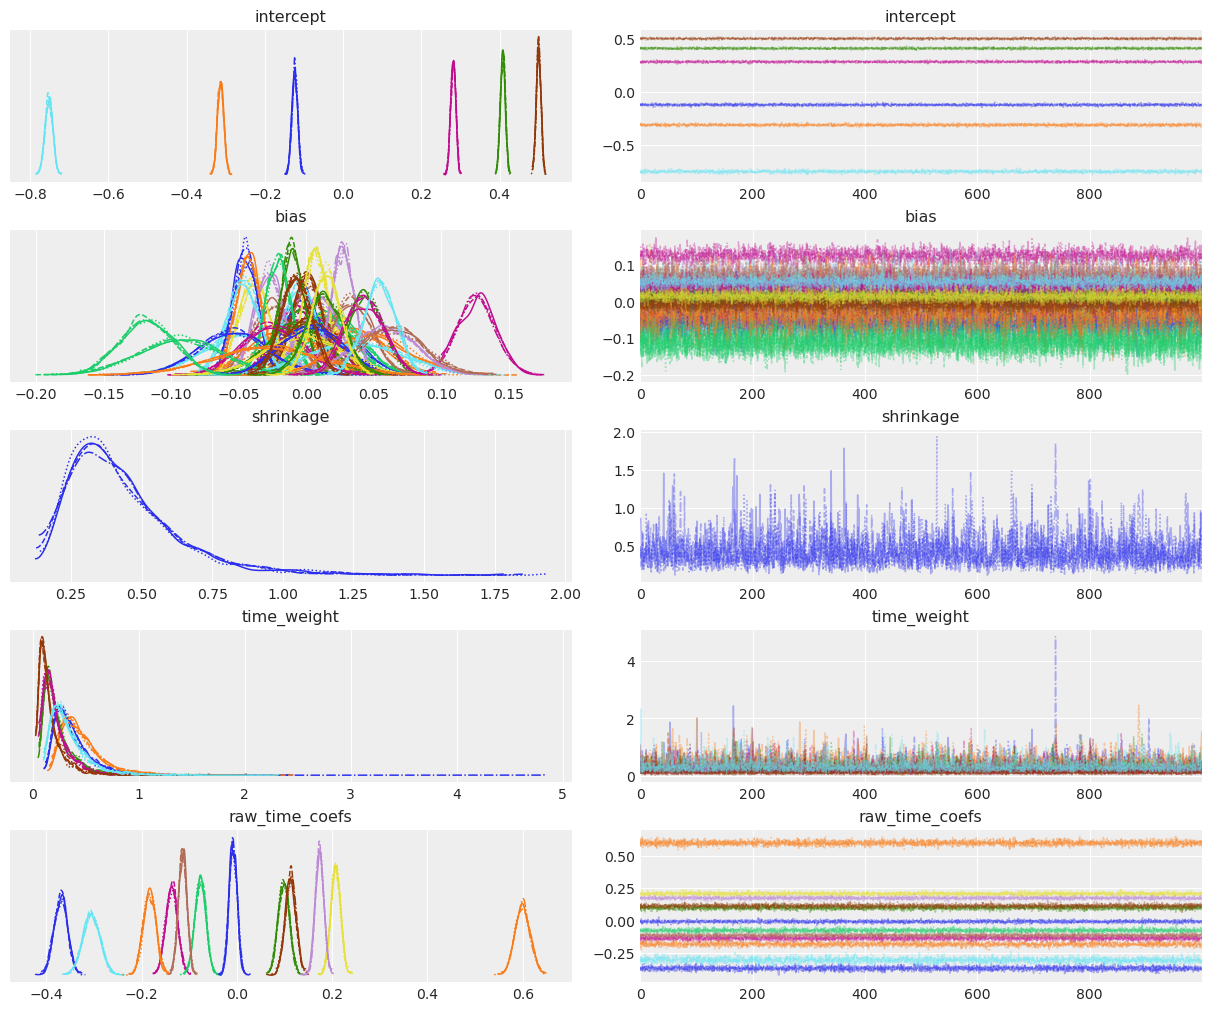

In [22]:
arviz.plot_trace(idata, var_names=["~time_effect", "~popularity"]);

In [23]:
summary = arviz.summary(
    idata,
    kind="diagnostics",
)

In [24]:
summary[summary["ess_bulk"] <= 800]

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat


In [25]:
def retrodictive_plot(trace: arviz.InferenceData, group: str = "posterior"):
    fig, axes = plt.subplots(4, 2, figsize=(12, 15), sharey=True)
    axes = axes.ravel()
    axes[-1].remove()
    colors = sns.color_palette("rocket", n_colors=7, as_cmap=False)

    N = trace.constant_data["observed_N"]
    if group == "posterior":
        var = trace.posterior_predictive
    elif group == "prior":
        var = trace.prior_predictive
    POST_MEANS = (var["N_approve"] / N).mean(("chain", "draw"))
    HDI = arviz.hdi(var)["N_approve"] / N

    for i, p in enumerate(COORDS["parties_complete"]):
        if group == "posterior":
            axes[i].plot(
                polls_train["date"],
                polls_train[p] / N,
                "o",
                color=colors[i],
                alpha=0.4,
            )
        axes[i].fill_between(
            polls_train["date"],
            HDI.sel(parties_complete=p, hdi="lower"),
            HDI.sel(parties_complete=p, hdi="higher"),
            color=colors[i],
            alpha=0.4,
        )
        axes[i].plot(
            polls_train["date"],
            POST_MEANS.sel(parties_complete=p),
            color=colors[i],
        )
        axes[i].tick_params(axis="x", labelrotation=45, labelsize=10)
        axes[i].set(title=p.title())
    plt.suptitle(f"{group.title()} Predictive Check", fontsize=16, fontweight="bold")

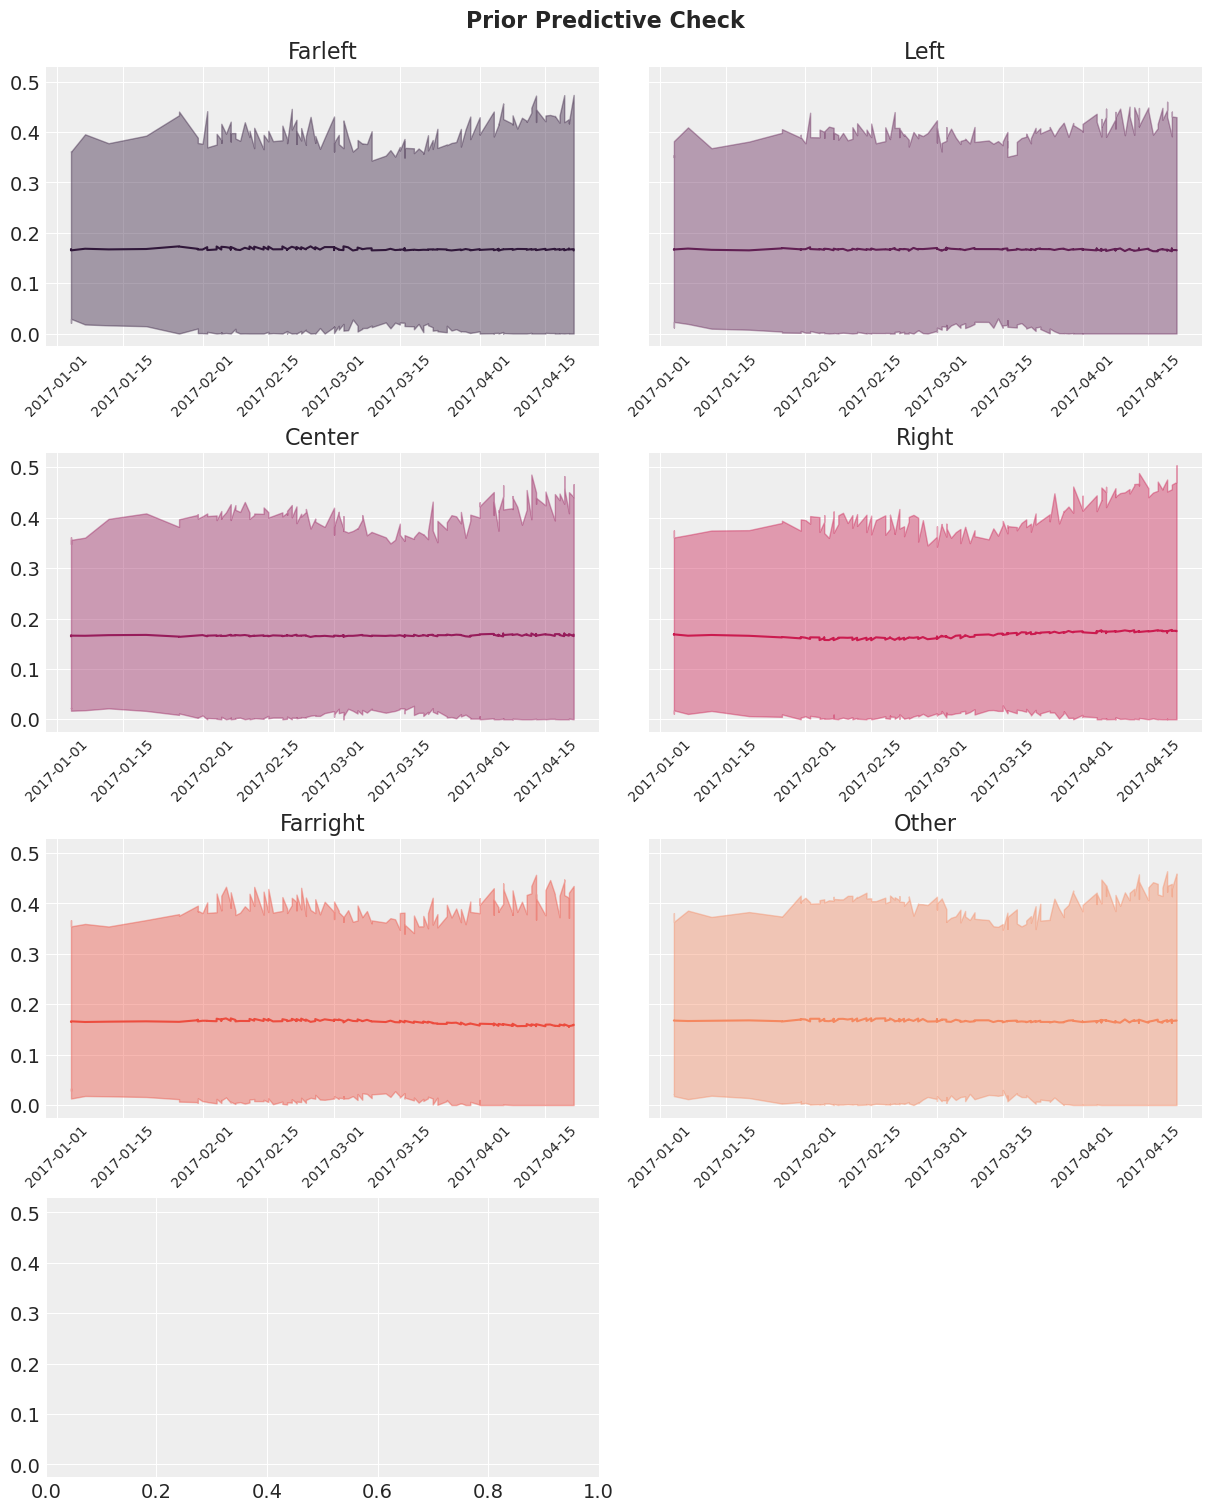

In [26]:
retrodictive_plot(idata, group="prior")

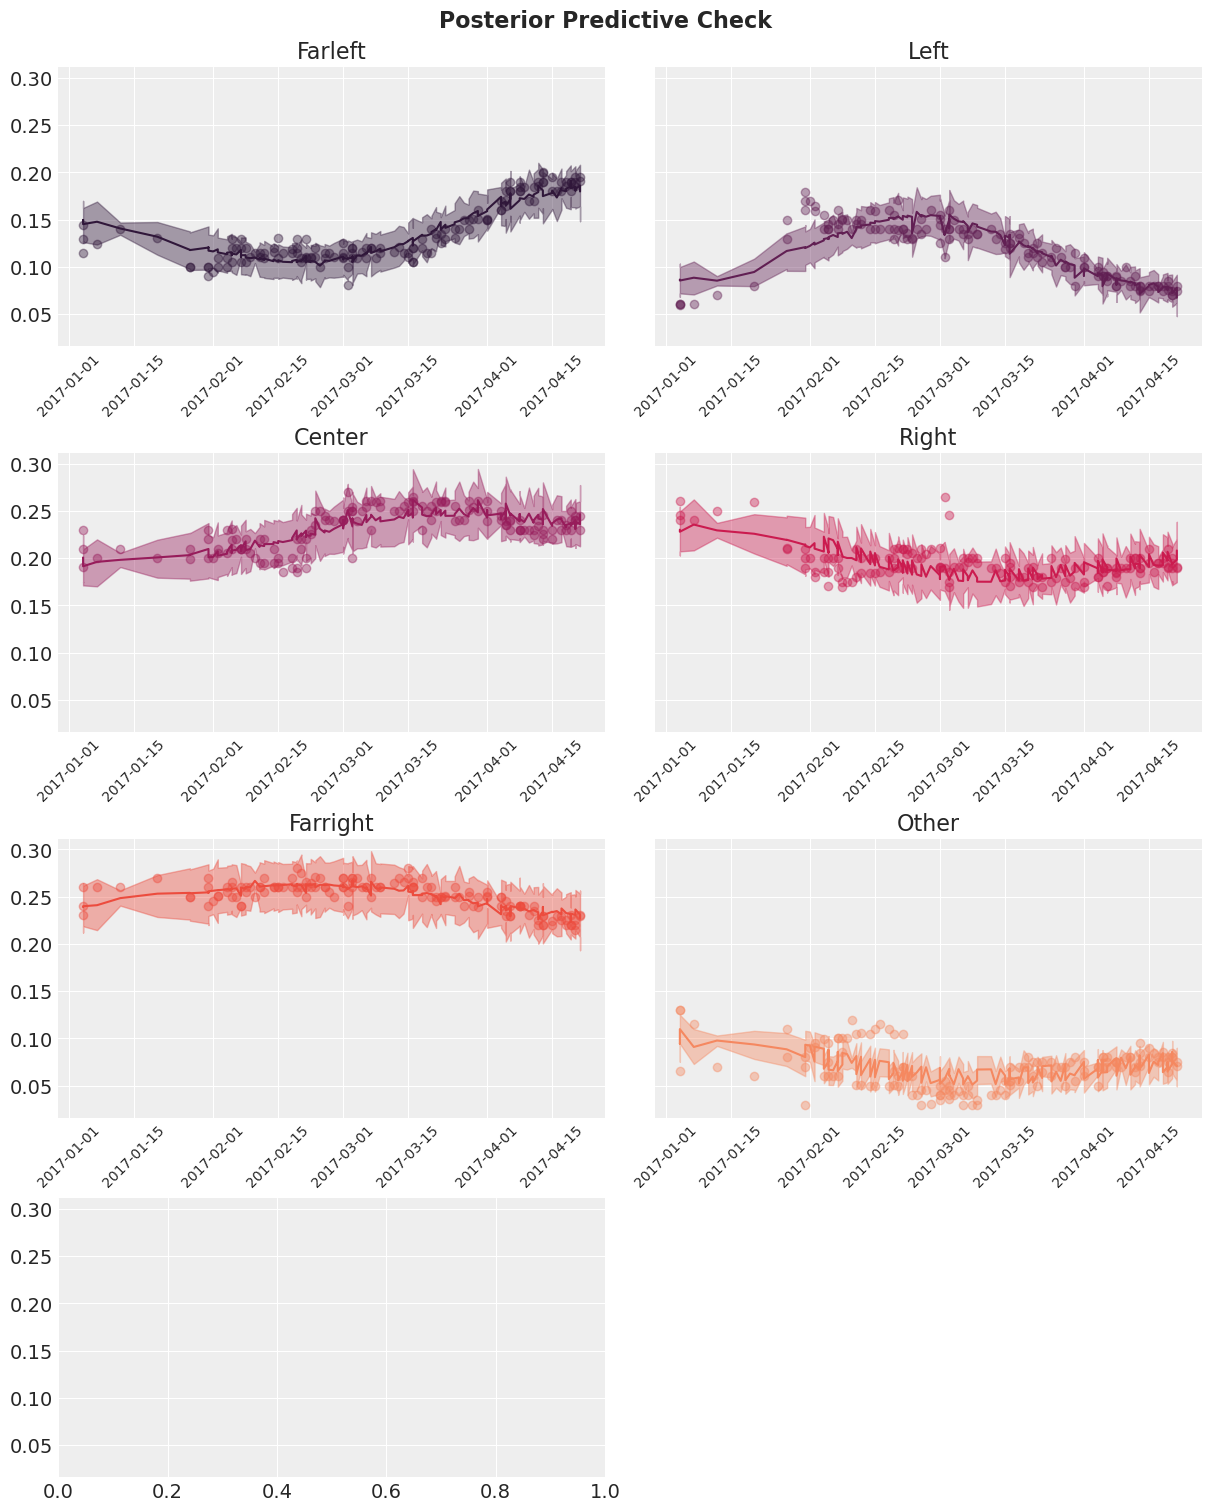

In [27]:
retrodictive_plot(idata)

In [28]:
with plain_mult:
    pm.set_data(
        {
            "pollster_idx": np.random.choice(pollster_id, size=len(estimated_days)),
            "observed_days_idx": estimated_days,
            "observed_N": np.random.choice(
                polls_train["samplesize"].values, size=len(estimated_days)
            ),
            "observed_polls": np.ones(
                (len(estimated_days), len(COORDS["parties_complete"])), dtype=int
            ),
        }
    )
    ppc = pm.sample_posterior_predictive(
        idata, var_names=["time_effect", "popularity", "N_approve"]
    )

In [29]:
PREDICTION_COORDS = {
    "observations": idata.posterior["estimated_days"],
    "estimated_days": idata.posterior["estimated_days"],
}
PREDICTION_DIMS = {
    "time_effect": ["estimated_days", "parties_complete"],
    "popularity": ["observations", "parties_complete"],
    "N_approve": ["observations", "parties_complete"],
}
with plain_mult:
    arviz.from_pymc3_predictions(
        ppc,
        idata_orig=idata,
        inplace=True,
        coords=PREDICTION_COORDS,
        dims=PREDICTION_DIMS,
    )

In [30]:
def predictive_plot(predictions: arviz.InferenceData):
    fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharey=True)
    axes = axes.ravel()
    #    axes[-1].remove()
    colors = sns.color_palette("rocket", n_colors=6, as_cmap=False)

    post_N = predictions.predictions_constant_data["observed_N"]
    POST_MEANS = predictions.predictions["popularity"].mean(("chain", "draw"))
    HDI_POP = arviz.hdi(predictions.predictions)["popularity"]
    HDI_MULT = arviz.hdi(predictions.predictions)["N_approve"] / post_N

    for i, p in enumerate(COORDS["parties_complete"]):
        axes[i].plot(
            polls_train["date"],
            polls_train[p] / polls_train["samplesize"],
            "o",
            color=colors[i],
            alpha=0.4,
            label="Observed polls",
        )
        if not polls_test.empty:
            axes[i].plot(
                polls_test["date"],
                polls_test[p] / polls_test["samplesize"],
                "x",
                color="red",
                alpha=0.4,
                label="Unobserved polls",
            )
        axes[i].plot(
            ELECTION_DAY,
            results[p] / 100,
            "s",
            color=colors[i],
            alpha=0.8,
            label="Result",
        )
        axes[i].fill_between(
            predictions.predictions["estimated_days"],
            HDI_MULT.sel(parties_complete=p, hdi="lower"),
            HDI_MULT.sel(parties_complete=p, hdi="higher"),
            color=colors[i],
            alpha=0.2,
            label="HDI Polls",
        )
        axes[i].fill_between(
            predictions.predictions["estimated_days"],
            HDI_POP.sel(parties_complete=p, hdi="lower"),
            HDI_POP.sel(parties_complete=p, hdi="higher"),
            color=colors[i],
            alpha=0.5,
            label="HDI Popularity",
        )
        axes[i].plot(
            predictions.predictions["estimated_days"],
            POST_MEANS.sel(parties_complete=p),
            color=colors[i],
            label="Mean Popularity",
        )
        axes[i].axvline(
            x=TEST_CUTOFF,
            ymin=-0.01,
            ymax=1.0,
            ls="--",
            c="k",
            alpha=0.4,
            label="Test cutoff",
        )
        axes[i].axvline(
            x=ELECTION_DAY,
            ymin=-0.01,
            ymax=1.0,
            ls=":",
            c="k",
            alpha=0.4,
            label="Election Day",
        )
        axes[i].tick_params(axis="x", labelrotation=45, labelsize=10)
        axes[i].set(title=p.title(), ylim=(-0.01, 0.4))
        axes[i].legend(fontsize=10, ncol=3)

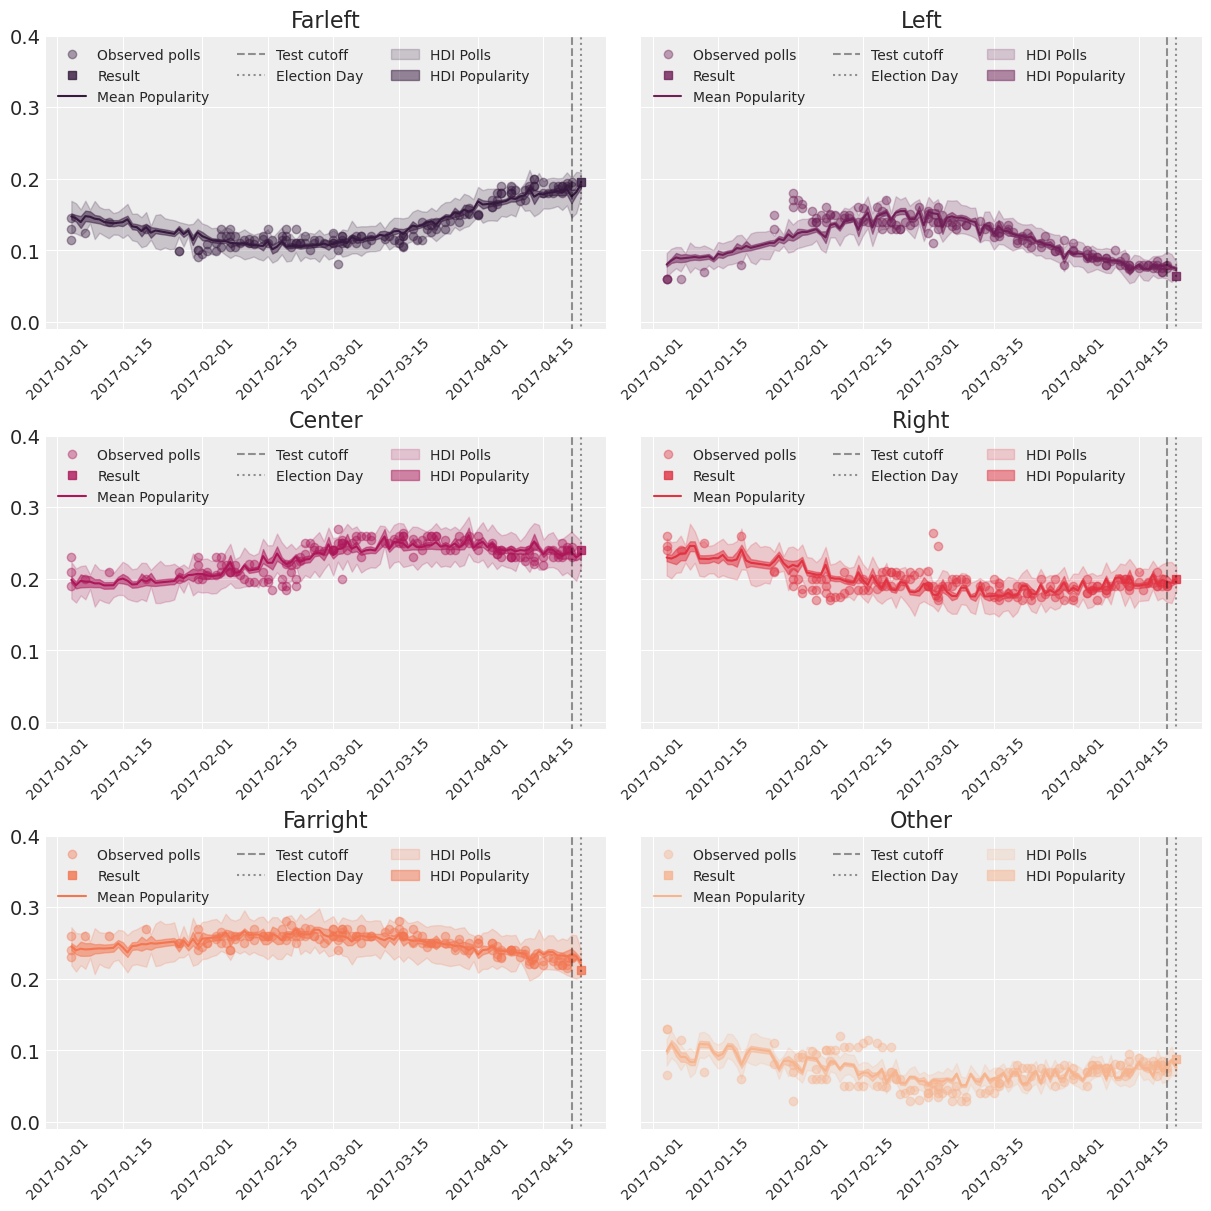

In [31]:
predictive_plot(idata)
plt.savefig("multinom_ppc.png")

In [34]:
%load_ext watermark
%watermark -n -u -v -iv -a "Alexandre Andorra & Rémi Louf"

Author: Alexandre Andorra & Rémi Louf

Last updated: Fri Sep 10 2021

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.22.0

arviz     : 0.11.2
matplotlib: 3.4.1
seaborn   : 0.11.1
xarray    : 0.17.0
pymc3     : 3.11.2
numpy     : 1.20.2
theano    : 1.1.2
pandas    : 1.2.4
scipy     : 1.6.2

